In [1]:
import re
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import networkx as nx
from networkx.algorithms.community import girvan_newman
import nltk
import string
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import hazm
from tqdm import tqdm
import spacy
from collections import Counter
from textblob import TextBlob

In [2]:
posts = pd.read_csv("dataset_facebook-posts-scraper_2024-01-19_16-59-15-417.csv")
posts

,comments,facebookId,facebookUrl,feedbackId,isVideo,likes,link,media/0/__isMedia,media/0/__typename,media/0/accent_color,...,text,time,timestamp,topLevelUrl,url,user/id,user/name,user/profilePic,user/profileUrl,viewsCount
0,2,100059174186752,https://www.facebook.com/nytimes/,ZmVlZGJhY2s6NzY2MjkwMDI1MzUzNDYz,NaN,11,https://nyti.ms/4b19VOp,GenericAttachmentMedia,GenericAttachmentMedia,NaN,...,This pen has been Wirecutter's favorite for a ...,2024-01-19T16:50:03.000Z,1705683003,https://www.facebook.com/100059174186752/posts...,https://www.facebook.com/nytimes/posts/pfbid0g...,100059174186752,The New York Times,https://scontent.fedi1-1.fna.fbcdn.net/v/t39.3...,https://www.facebook.com/nytimes,NaN
1,0,100064287655664,https://www.facebook.com/GuardianUs/,ZmVlZGJhY2s6NzU3MjkwNDQ2NDIzODcw,NaN,0,https://www.theguardian.com/environment/2024/j...,GenericAttachmentMedia,GenericAttachmentMedia,NaN,...,NaN,2024-01-19T16:47:16.000Z,1705682836,https://www.facebook.com/100064287655664/posts...,https://www.facebook.com/GuardianUs/posts/pfbi...,100064287655664,Guardian US,https://scontent-iad3-1.xx.fbcdn.net/v/t39.308...,https://www.facebook.com/GuardianUs,NaN
2,7,100059174186752,https://www.facebook.com/nytimes/,ZmVlZGJhY2s6NzY2Mjg1NDE1MzUzOTI0,NaN,36,https://nyti.ms/48XGL0N,GenericAttachmentMedia,GenericAttachmentMedia,NaN,...,From The Athletic FC: In over six seasons at L...,2024-01-19T16:40:11.000Z,1705682411,https://www.facebook.com/100059174186752/posts...,https://www.facebook.com/nytimes/posts/pfbid0T...,100059174186752,The New York Times,https://scontent-lhr6-1.xx.fbcdn.net/v/t39.308...,https://www.facebook.com/nytimes,NaN
3,2,100044328734711,https://www.facebook.com/bbc/,ZmVlZGJhY2s6OTE3NDExMDIzMDc5ODQ3,True,2,NaN,NaN,Video,NaN,...,Terrifying 😱 #TheTraitors #iPlayer,2024-01-19T16:30:59.000Z,1705681859,https://www.facebook.com/100044328734711/posts...,https://www.facebook.com/bbc/posts/pfbid03h2SB...,100044328734711,BBC,https://scontent.ftpa1-2.fna.fbcdn.net/v/t39.3...,https://www.facebook.com/bbc,259.0
4,178,100059479812265,https://www.facebook.com/cnn/,ZmVlZGJhY2s6NzY0MjkzMDU4ODk2Njgx,NaN,285,https://www.cnn.com/2024/01/19/sport/buffalo-b...,GenericAttachmentMedia,GenericAttachmentMedia,NaN,...,Volunteers will be paid $20 per hour and “a co...,2024-01-19T16:30:10.000Z,1705681810,https://www.facebook.com/100059479812265/posts...,https://www.facebook.com/cnn/posts/pfbid036LgV...,100059479812265,CNN,https://scontent.flas1-2.fna.fbcdn.net/v/t39.3...,https://www.facebook.com/cnn,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
734,163,100059479812265,https://www.facebook.com/cnn/,ZmVlZGJhY2s6NzYzNzI3MzYyMjg2NTg0,NaN,572,https://www.cnn.com/2024/01/18/us/a-barking-do...,GenericAttachmentMedia,GenericAttachmentMedia,NaN,...,Rescuers repelled down a steep mountain slope ...,2024-01-18T17:30:12.000Z,1705599012,https://www.facebook.com/100059479812265/posts...,https://www.facebook.com/cnn/posts/pfbid0WLTUo...,100059479812265,CNN,https://scontent-ord5-1.xx.fbcdn.net/v/t39.308...,https://www.facebook.com/cnn,NaN
735,43,100044328734711,https://www.facebook.com/bbc/,ZmVlZGJhY2s6OTE1NDM2ODgzMjc3MjYx,NaN,118,https://www.bbc.co.uk/news/world-us-canada-679...,GenericAttachmentMedia,GenericAttachmentMedia,NaN,...,Donald Trump won by a landslide in the first c...,2024-01-16T11:30:14.000Z,1705404614,https://www.facebook.com/100044328734711/posts...,https://www.facebook.com/bbc/posts/pfbid02tE8f...,100044328734711,BBC,https://scontent-atl3-1.xx.fbcdn.net/v/t39.308...,https://www.facebook.com/bbc,NaN
736,1,100070145124522,https://www.facebook.com/Iran/,ZmVlZGJhY2s6NDg0NjUyNzI5ODg2MDk3,NaN,43,NaN,Photo,Photo,FF190F06,...,"Nasir Al-Mulk Mosque, An Exquisite Place\n\nمس...",2022-03-05T10:31:26.000Z,1646476286,https://www.facebook.com/100070145124522/posts...,https://www.facebook.com/Iran/posts/pfbid0HgM7...,100070145124522,Iran l ایران,https://scontent-yyz1-1.xx.fbcdn.net/v/t39.308...,https://www.facebook.com/Iran,NaN


In [3]:
with open("posts_file.txt", "w") as file:
    for url in posts['url']:
        file.write(url + "\n")

In [4]:
likes = pd.read_csv("dataset_facebook-likes-scraper_2024-01-19_17-09-49-506.csv")
likes

,facebookId,facebookUrl,name,pageAdLibrary/id,pageAdLibrary/is_business_page_active,profileUrl,reaction
0,757195683100013,https://www.facebook.com/GuardianUs/posts/7571...,Tom Traub,4.567402e+14,False,https://www.facebook.com/pfbid0grPumr3VKEqnV38...,like
1,757195683100013,https://www.facebook.com/GuardianUs/posts/7571...,Kaung Sett,4.567402e+14,False,https://www.facebook.com/pfbid0gnuDXMthcAWAtM3...,like
2,896132472177605,https://www.facebook.com/dw.persian/posts/pfbi...,لعل محمد ابراهیمی,1.181850e+14,False,https://www.facebook.com/pfbid02xnK6GRqmjHRGFb...,like
3,896132472177605,https://www.facebook.com/dw.persian/posts/pfbi...,محمد عیسی محمدی,1.181850e+14,False,https://www.facebook.com/pfbid02GVm9j7eXRVVe73...,like
4,896132472177605,https://www.facebook.com/dw.persian/posts/pfbi...,Mohamad Zoyavar,1.181850e+14,False,https://www.facebook.com/pfbid02VbY7LJyhvqdJ4k...,like
...,...,...,...,...,...,...,...
1642,917233189764297,https://www.facebook.com/bbc/posts/pfbid0qxePq...,Chris Webby,NaN,NaN,https://www.facebook.com/pfbid02SnA9DtFmFLjLpn...,like
1643,10158482606717890,https://www.facebook.com/tehran.bureau/posts/p...,Dayyabu Ahmad,1.829788e+10,False,https://www.facebook.com/pfbid02SkQo6eBNPiQDwK...,like
1644,10158482606717890,https://www.facebook.com/tehran.bureau/posts/p...,Berg Pereira,1.829788e+10,False,https://www.facebook.com/pfbid02gKvcW5aCsEb2Vx...,like
1645,10158482606717890,https://www.facebook.com/tehran.bureau/posts/p...,Amahd François,1.829788e+10,False,https://www.facebook.com/pfbid0du9uY4csdUQwD9N...,like


# Gathering the Most Important parts of the Dataset

In [5]:
posts = posts[['url', 'text', 'likes', 'user/name', 'time']]
posts

,url,text,likes,user/name,time
0,https://www.facebook.com/nytimes/posts/pfbid0g...,This pen has been Wirecutter's favorite for a ...,11,The New York Times,2024-01-19T16:50:03.000Z
1,https://www.facebook.com/GuardianUs/posts/pfbi...,NaN,0,Guardian US,2024-01-19T16:47:16.000Z
2,https://www.facebook.com/nytimes/posts/pfbid0T...,From The Athletic FC: In over six seasons at L...,36,The New York Times,2024-01-19T16:40:11.000Z
3,https://www.facebook.com/bbc/posts/pfbid03h2SB...,Terrifying 😱 #TheTraitors #iPlayer,2,BBC,2024-01-19T16:30:59.000Z
4,https://www.facebook.com/cnn/posts/pfbid036LgV...,Volunteers will be paid $20 per hour and “a co...,285,CNN,2024-01-19T16:30:10.000Z
...,...,...,...,...,...
734,https://www.facebook.com/cnn/posts/pfbid0WLTUo...,Rescuers repelled down a steep mountain slope ...,572,CNN,2024-01-18T17:30:12.000Z
735,https://www.facebook.com/bbc/posts/pfbid02tE8f...,Donald Trump won by a landslide in the first c...,118,BBC,2024-01-16T11:30:14.000Z
736,https://www.facebook.com/Iran/posts/pfbid0HgM7...,"Nasir Al-Mulk Mosque, An Exquisite Place\n\nمس...",43,Iran l ایران,2022-03-05T10:31:26.000Z
737,https://www.facebook.com/iranintl/posts/pfbid0...,الیزابت استیکنی، از سخنگویان وزارت خارجه آمری...,505,Iran International ايران اينترنشنال,2024-01-19T01:47:14.000Z


In [6]:
likes = likes[['facebookUrl', 'name', 'reaction']]
likes

,facebookUrl,name,reaction
0,https://www.facebook.com/GuardianUs/posts/7571...,Tom Traub,like
1,https://www.facebook.com/GuardianUs/posts/7571...,Kaung Sett,like
2,https://www.facebook.com/dw.persian/posts/pfbi...,لعل محمد ابراهیمی,like
3,https://www.facebook.com/dw.persian/posts/pfbi...,محمد عیسی محمدی,like
4,https://www.facebook.com/dw.persian/posts/pfbi...,Mohamad Zoyavar,like
...,...,...,...
1642,https://www.facebook.com/bbc/posts/pfbid0qxePq...,Chris Webby,like
1643,https://www.facebook.com/tehran.bureau/posts/p...,Dayyabu Ahmad,like
1644,https://www.facebook.com/tehran.bureau/posts/p...,Berg Pereira,like
1645,https://www.facebook.com/tehran.bureau/posts/p...,Amahd François,like


# Creating the Network

In [7]:
Net = nx.DiGraph()

Net.add_nodes_from(likes['name'])
Net.add_nodes_from(posts['user/name'])

In [8]:
for idx, like in tqdm(likes.iterrows()):
    for _, post in posts.iterrows():
        if post['url'] == like['facebookUrl']:
            Net.add_edge(like['name'], post['user/name'])

1647it [00:55, 29.57it/s]


H:\Python Environments\SNA\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 3623 (\N{THAI CHARACTER WO WAEN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
H:\Python Environments\SNA\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 3636 (\N{THAI CHARACTER SARA I}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
H:\Python Environments\SNA\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 3619 (\N{THAI CHARACTER RO RUA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
H:\Python Environments\SNA\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 3632 (\N{THAI CHARACTER SARA A}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
H:\Python Environments\SNA\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 3594 (\N{THAI CHARACTER CHO CHANG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
H:\Pyt

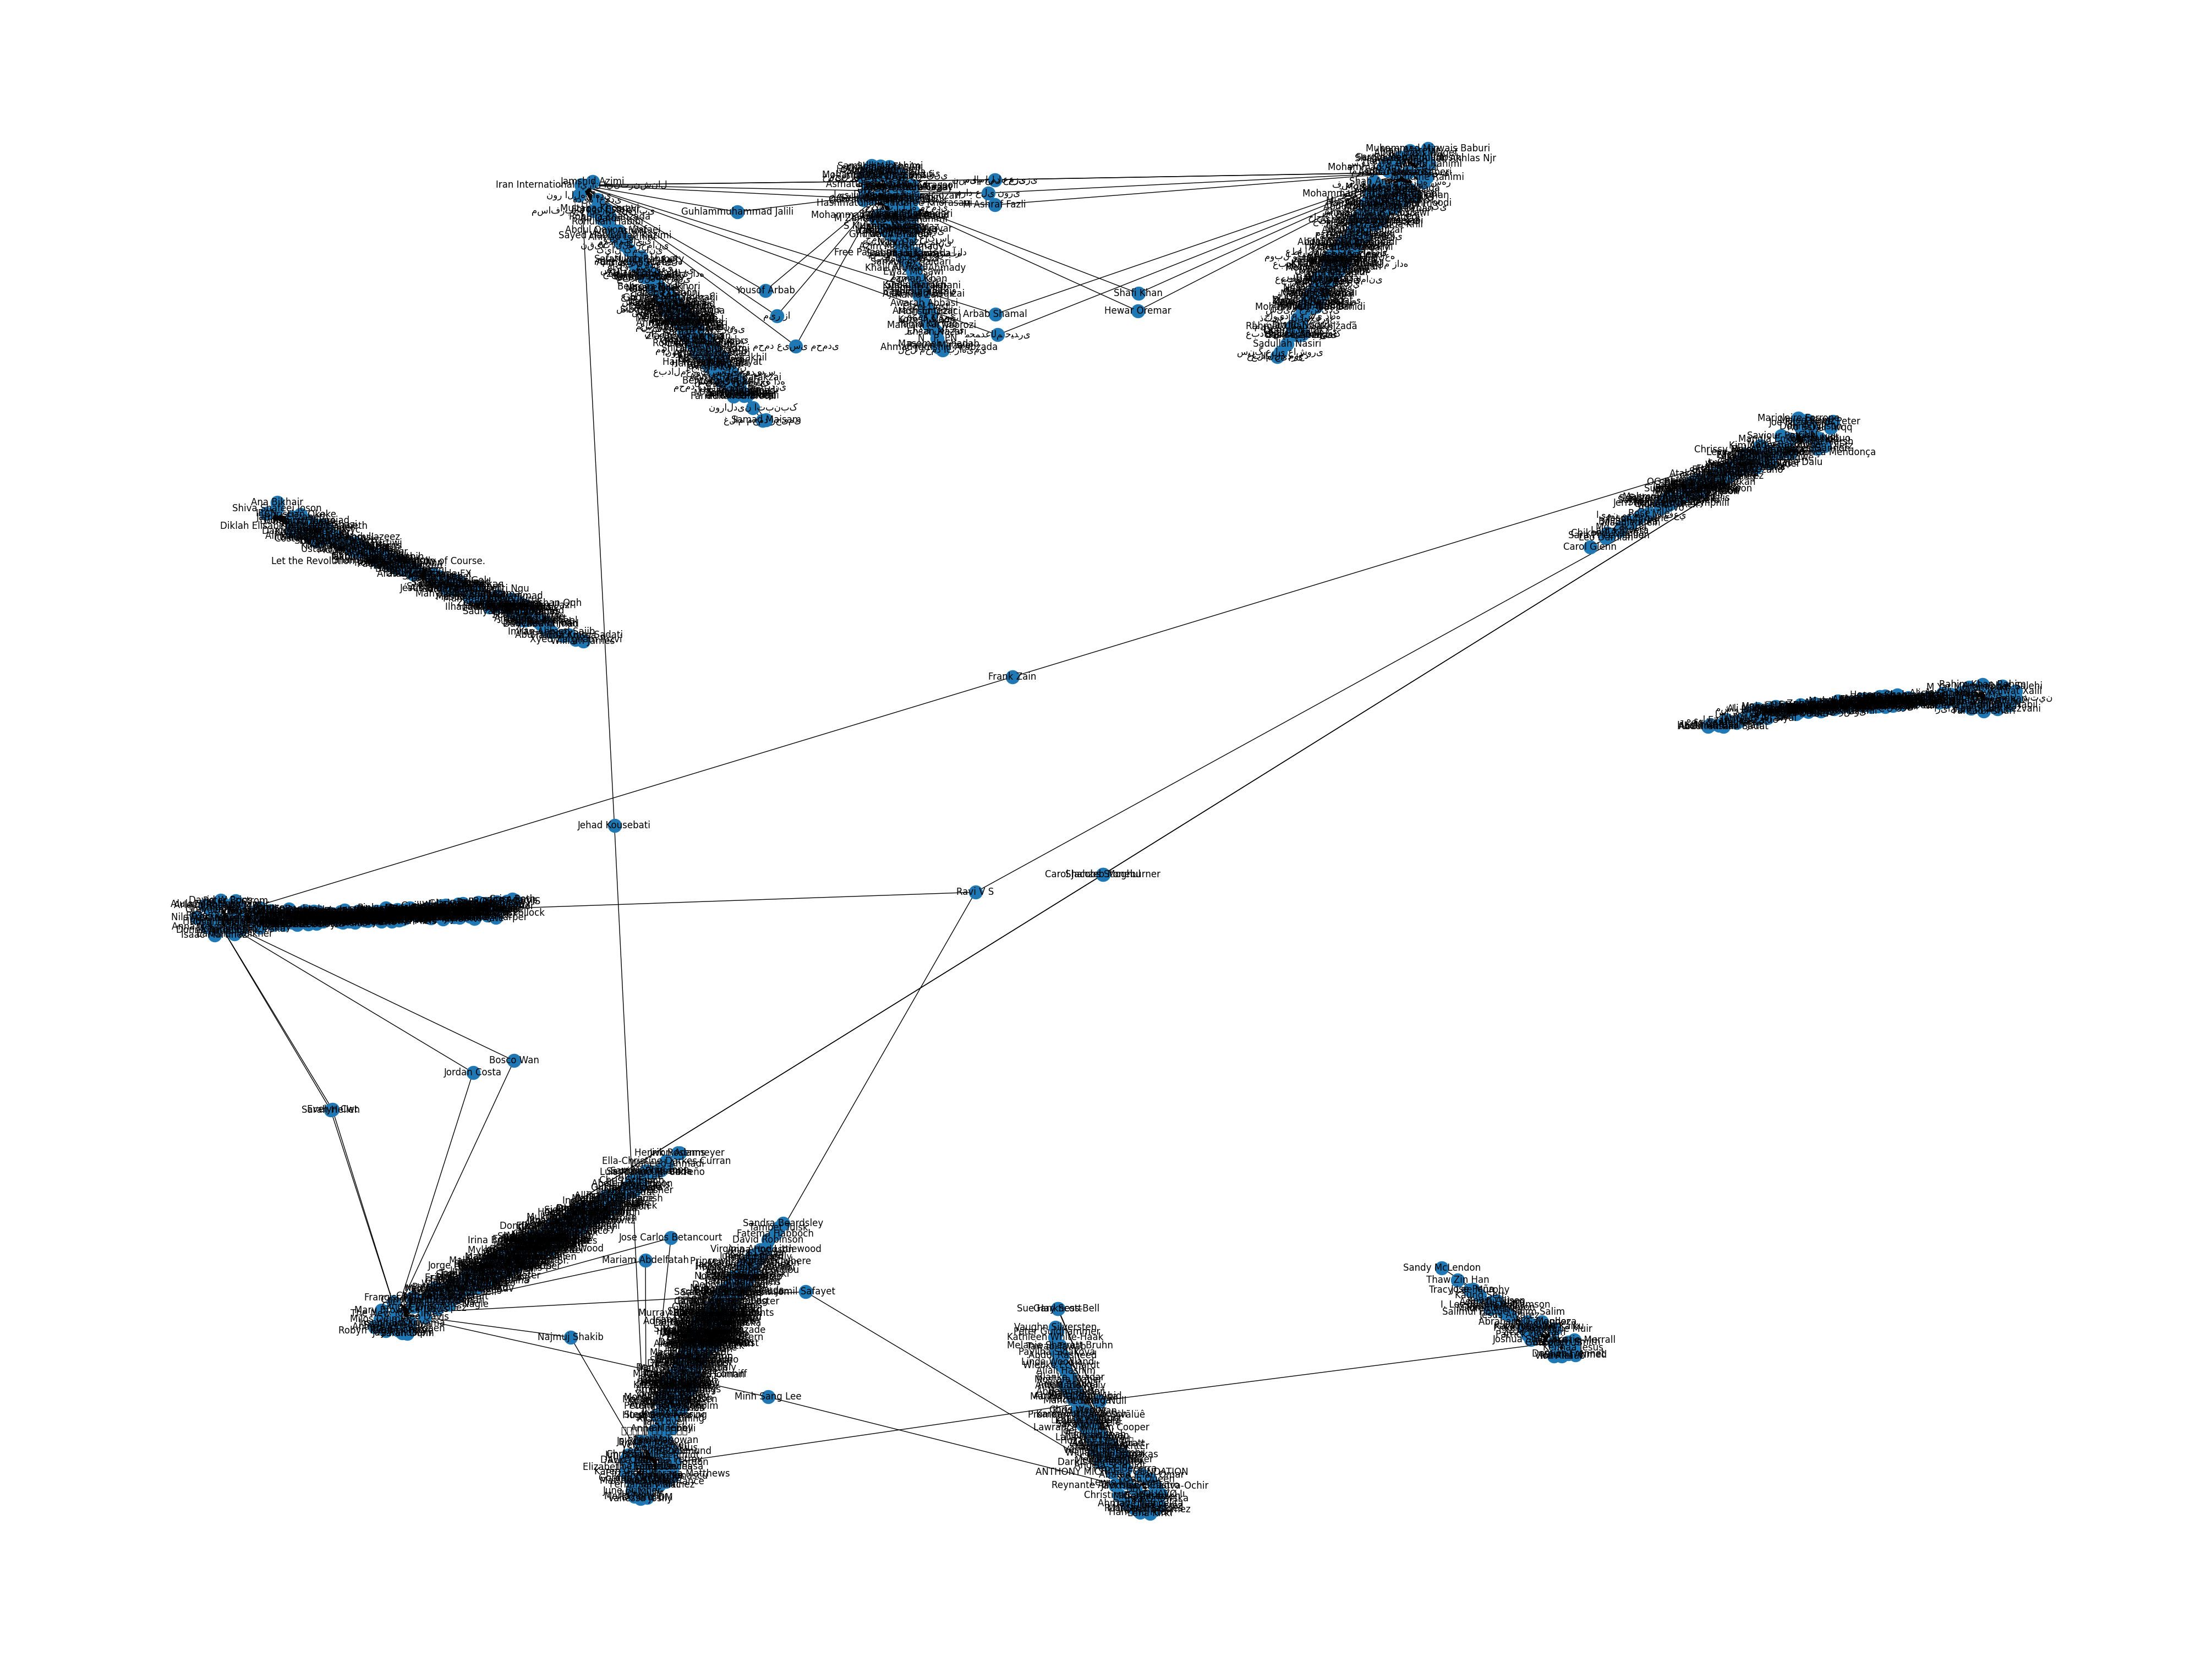

In [9]:
# Showing the Network
plt.figure(figsize=(40,30))
nx.draw(Net, with_labels=True)
plt.show()

# Calculating the Centrality Measures

## Degree Centrality

In [10]:
deg_cent = sorted(nx.degree_centrality(Net).items(), key=lambda x:x[1])
deg_cent[-5:]

[('Iran International ايران اينترنشنال', 0.09955423476968796),
 ('BBC News فارسی', 0.10326894502228826),
 ('ABC News', 0.12407132243684992),
 ('The New York Times', 0.14710252600297177),
 ('The Guardian', 0.1701337295690936)]

## Closness Centrality

In [11]:
closness = sorted(nx.closeness_centrality(Net).items(), key=lambda x:x[1])
closness[-5:]

[('Iran International ايران اينترنشنال', 0.09955423476968796),
 ('BBC News فارسی', 0.10326894502228826),
 ('ABC News', 0.12407132243684993),
 ('The New York Times', 0.14710252600297177),
 ('The Guardian', 0.17013372956909362)]

## Betweenness Centrality

In [12]:
betweenness = sorted(nx.betweenness_centrality(Net, normalized=True).items(), key=lambda x:x[1])
betweenness[-5:]

[('The Guardian', 0.0),
 ('BBC News فارسی', 0.0),
 ('Iran l ایران', 0.0),
 ('IRAN', 0.0),
 ('DW فارسی', 0.0)]

## Eigenvector Centrality

In [13]:
eigenvector = sorted(nx.eigenvector_centrality(Net).items(), key=lambda x:x[1])
eigenvector[-5:]

[('Iran International ايران اينترنشنال', 0.29801216834215577),
 ('BBC News فارسی', 0.3091302968050995),
 ('ABC News', 0.37139181619758493),
 ('The New York Times', 0.44032421266783545),
 ('The Guardian', 0.5092566091381203)]

## Katz Centrality

In [14]:
katz = sorted(nx.katz_centrality(Net).items(), key=lambda x:x[1])
katz[-5:]

[('Iran International ايران اينترنشنال', 0.23861639081098665),
 ('BBC News فارسی', 0.24690168215859035),
 ('ABC News', 0.2932993137051711),
 ('The New York Times', 0.34466812006031405),
 ('The Guardian', 0.396036926415457)]

## PageRank Centrality

In [15]:
page_rank = sorted(nx.pagerank(Net, alpha=0.8).items(), key=lambda x:x[1])
page_rank[-5:]

[('Iran International ايران اينترنشنال', 0.04288624148324172),
 ('BBC News فارسی', 0.04503742575707601),
 ('ABC News', 0.054635017132644445),
 ('The New York Times', 0.06412229136596505),
 ('The Guardian', 0.07515400559075644)]

# Finding the 25 +/- Words in the Network!


## Download The Needed Basic data for NLP Tasks

In [16]:
nltk.download("stopwords")
nltk.download("punkt")
nltk.download("vader_lexicon")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sorou\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\sorou\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\sorou\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [17]:
ENGLISH_STOPWORDS = stopwords.words('english')
FA_STOPWORDS = hazm.stopwords_list()
STOP_WORDS = ENGLISH_STOPWORDS + FA_STOPWORDS

PUNCTUATIONS = string.punctuation + "©"

In [18]:
def preprocess(input_str: str):
    input_str = input_str.lower()
    input_str = input_str.strip()
    input_str = re.sub(r"https?://(?:[-\w.]|(?:%[\da-fA-F]{2}))+(/\S+)?|\S+\.com\S+", "", input_str)
    
    # remove the hashtags and mentions
    input_str = re.sub(r"#\w+|@\w+", "", input_str)
    input_str = re.sub(rf"[{PUNCTUATIONS}]", "", input_str)

    webpattern = re.compile("["
                            u"\U0001F600-\U0001F64F"
                            u"\U0001F300-\U0001F5FF"
                            u"\U0001F680-\U0001F6FF"
                            u"\U0001F1E0-\U0001F1FF"
                            u"\U00002500-\U00002BEF"
                            u"\U00002702-\U000027B0"
                            u"\U00002702-\U000027B0"
                            u"\U000024C2-\U0001F251"
                            u"\U0001f926-\U0001f937"
                            u"\U00010000-\U0010ffff"
                            u"\u2640-\u2642"
                            u"\u2600-\u2B55"
                            u"\u200d"
                            u"\u23cf"
                            u"\u23e9"
                            u"\u231a"
                            u"\ufe0f"
                            u"\u3030"
                            u"\u200e-\u200f"
                            "]+", flags=re.UNICODE)
    input_str = webpattern.sub(r'', input_str)

    stop_words = set(STOP_WORDS)
    word_tokens = word_tokenize(input_str)
    input_str = [word for word in word_tokens if word not in stop_words]
    return " ".join(input_str)

In [19]:
def sentiment_analysis(input_str: str):
    vader_analyzer = SentimentIntensityAnalyzer()
    sentiment_result_vader = vader_analyzer.polarity_scores(input_str)

    sentiment_status = "Neutral"
    
    if sentiment_result_vader["compound"] > 0:
        sentiment_status = "Positive"
    elif sentiment_result_vader["compound"] < 0:
        sentiment_status = "Negative"
    elif sentiment_result_vader["compound"] == 0:
        sentiment_status = "Neutral"
    
    return sentiment_status

# Making a Text of all Posts to Extract most Important Keywords

In [20]:
text = ""
for txt in posts['text']:
    text += str(txt)

text

'This pen has been Wirecutter\'s favorite for a decade. It’s unassuming. But it’s special.nanFrom The Athletic FC: In over six seasons at Liverpool, Mohamed Salah has missed just 10 Premier League games. A rare injury while playing for Egypt at the Africa Cup of Nations is of deep concern to his club and country  — their hopes of glory rest on him.Terrifying 😱 #TheTraitors #iPlayerVolunteers will be paid $20 per hour and “a comfortable warm break area will be provided.”تاج\u200cالدین سروش، ایران اینترنشنال از اطلاعیه جدید وزارت اطلاعات درباره انفجارهای مرگبار مراسم قاسم سلیمانی می\u200cگویدnanFord is cutting production of the F-150 Lightning electric pickup after weaker-than-expected electric vehicle sales growth. https://abcnews.visitlink.me/fe-filBREAKING NEWSIs Jaz the Maddie of Series 2? 👀 #TheTraitors #iPlayer #SherlockHolmesnanافزایش تنش\u200cها در منطقه و احتمال تبدیل آن به یک بحران فراگیر\n\nگفت\u200cوگو با فرزین ندیمی، تحلیلگر امور دفاعی و امنیتی در موسسه واشینگتنتانک\u200cهای

# Finding Key Words

In [21]:
pre_proceesed_text = preprocess(text)
nlp = spacy.load("en_core_web_sm")
doc = nlp(pre_proceesed_text)

words = [token.text for token in doc if not token.is_stop and not token.is_punct]
word_freq = Counter(words)
common_words = word_freq.most_common(25)

print(common_words)

[('ایران', 256), ('پاکستان', 198), ('حمله', 135), ('کشور', 120), ('روز', 92), ('اسلامی', 88), ('اسرائیل', 85), ('جمهوری', 82), ('حملات', 75), ('قرار', 71), ('آمریکا', 67), ('گزارش', 57), ('سال', 56), ('خارجه', 55), ('کشته', 51), ('منطقه', 50), ('دولت', 50), ('غزه', 47), ('وزارت', 45), ('هدف', 45), ('بلوچستان', 45), ('اعلام', 42), ('انجام', 42), ('است', 41), ('جنگ', 41)]


# Finding +/- of the Keywords

In [22]:
def word_pos_neg (word: str):
    blob = TextBlob(word)
    polarity = blob.sentiment.polarity
    
    if polarity > 0:
        return "Positive"
    if polarity < 0:
        return "Negative"
    
    return "Neutral"

In [23]:
keywords = []
repeats = []
sentiment = []
for key_word, repeat in tqdm(common_words):
    keywords.append(key_word)
    repeats.append(repeat)
    sentiment.append(word_pos_neg(key_word))

100%|██████████| 25/25 [00:00<00:00, 833.37it/s]


In [24]:
KeyWords_df = pd.DataFrame({'word': keywords, 'repeat': repeats, 'sentiment': sentiment})
KeyWords_df

,word,repeat,sentiment
0,ایران,256,Neutral
1,پاکستان,198,Neutral
2,حمله,135,Neutral
3,کشور,120,Neutral
4,روز,92,Neutral
5,اسلامی,88,Neutral
6,اسرائیل,85,Neutral
7,جمهوری,82,Neutral
8,حملات,75,Neutral
9,قرار,71,Neutral



# Finding which posts are + and which are -

In [25]:
# sample_posts_idx = np.random.randint(0, len(posts['text']), size=len(posts['text']))
sample_posts_idx = range(len(posts))

In [26]:
preprocessed_texts = []
for idx in tqdm(sample_posts_idx):
    preprocessed_texts.append(preprocess(str(posts['text'][idx])))

100%|██████████| 739/739 [00:00<00:00, 4345.59it/s]


In [27]:
preprocessed_df = pd.DataFrame({'text': preprocessed_texts})
preprocessed_df

,text
0,pen wirecutters favorite decade ’ unassuming ’...
1,nan
2,athletic fc six seasons liverpool mohamed sala...
3,terrifying
4,volunteers paid 20 per hour “ comfortable warm...
...,...
734,rescuers repelled steep mountain slope hawaii ...
735,donald trump landslide first contest republica...
736,nasir almulk mosque exquisite place مسجد نصیرا...
737,الیزابت استیکنی، سخنگویان وزارت خارجه آمریکا،...


In [28]:
sentimented_texts = []
for txt in tqdm(preprocessed_texts):
    sentimented_texts.append(sentiment_analysis(txt))

100%|██████████| 739/739 [00:04<00:00, 171.24it/s]


In [29]:
sentimented_df = pd.DataFrame({'text': preprocessed_texts, 'sentiment': sentimented_texts})
sentimented_df

,text,sentiment
0,pen wirecutters favorite decade ’ unassuming ’...,Positive
1,nan,Neutral
2,athletic fc six seasons liverpool mohamed sala...,Positive
3,terrifying,Negative
4,volunteers paid 20 per hour “ comfortable warm...,Positive
...,...,...
734,rescuers repelled steep mountain slope hawaii ...,Positive
735,donald trump landslide first contest republica...,Neutral
736,nasir almulk mosque exquisite place مسجد نصیرا...,Neutral
737,الیزابت استیکنی، سخنگویان وزارت خارجه آمریکا،...,Neutral


In [30]:
positive_count = sentimented_df[sentimented_df['sentiment'] == "Positive"]
negative_count = sentimented_df[sentimented_df['sentiment'] == "Negative"]
neural_count = sentimented_df[sentimented_df['sentiment'] == "Neutral"]

print("============================================================")
print(f"THERE ARE {len(positive_count)} + POSTS")
print(f"THERE ARE {len(negative_count)} - POSTS")
print(f"THERE ARE {len(neural_count)} NEURAL POSTS")
print("============================================================")
print(f"Totally we can say that {(len(positive_count)/len(posts))*100:.2f}% are Positive")
print(f"Totally we can say that {(len(negative_count)/len(posts))*100:.2f}% are Negative")
print(f"Totally we can say that {(len(neural_count)/len(posts))*100:.2f}% are Neural")

THERE ARE 131 + POSTS
THERE ARE 103 - POSTS
THERE ARE 505 NEURAL POSTS
Totally we can say that 17.73% are Positive
Totally we can say that 13.94% are Negative
Totally we can say that 68.34% are Neural


# What does the whole Net thinks?

In [31]:
print("============================================================")
print(f"We do believe: {sentiment_analysis(pre_proceesed_text)}!")
print("============================================================")

We do believe: Positive!


# THE MOST ACTIVE USERS IN Network

In [34]:
most_active_users = likes['name'].value_counts(sort=True)
# active_user = most_active_users.sort_values('count', ascending=False)

print("============================================================")
print("\t THE MOST ACTIVE USERS ARE:")
print("============================================================")
for idx in range(15):
    print(f"NUM: {idx + 1} Name: {most_active_users.index[idx]} #OF LIKES: {most_active_users.iloc[idx]}")

	 THE MOST ACTIVE USERS ARE:
NUM: 1 Name: Mariam Abdelfatah #OF LIKES: 8
NUM: 2 Name: Shahzada Asadullah Akhlas Njr #OF LIKES: 7
NUM: 3 Name: Bella Bey #OF LIKES: 6
NUM: 4 Name: Mykyta Vitaliy Mckenzie #OF LIKES: 6
NUM: 5 Name: محمد افطيس #OF LIKES: 6
NUM: 6 Name: Ghulam Ali Yaqubi #OF LIKES: 6
NUM: 7 Name: Ali Maina Abubakar #OF LIKES: 6
NUM: 8 Name: วิระชัย ใจปลื้ม #OF LIKES: 5
NUM: 9 Name: Dayyabu Ahmad #OF LIKES: 5
NUM: 10 Name: Amahd François #OF LIKES: 5
NUM: 11 Name: Alice Smith #OF LIKES: 5
NUM: 12 Name: Mickey Banny #OF LIKES: 5
NUM: 13 Name: Andrew Lee #OF LIKES: 5
NUM: 14 Name: Wisdom Onobun #OF LIKES: 5
NUM: 15 Name: Sandra Willy #OF LIKES: 5


# Detecting Communities in the Network

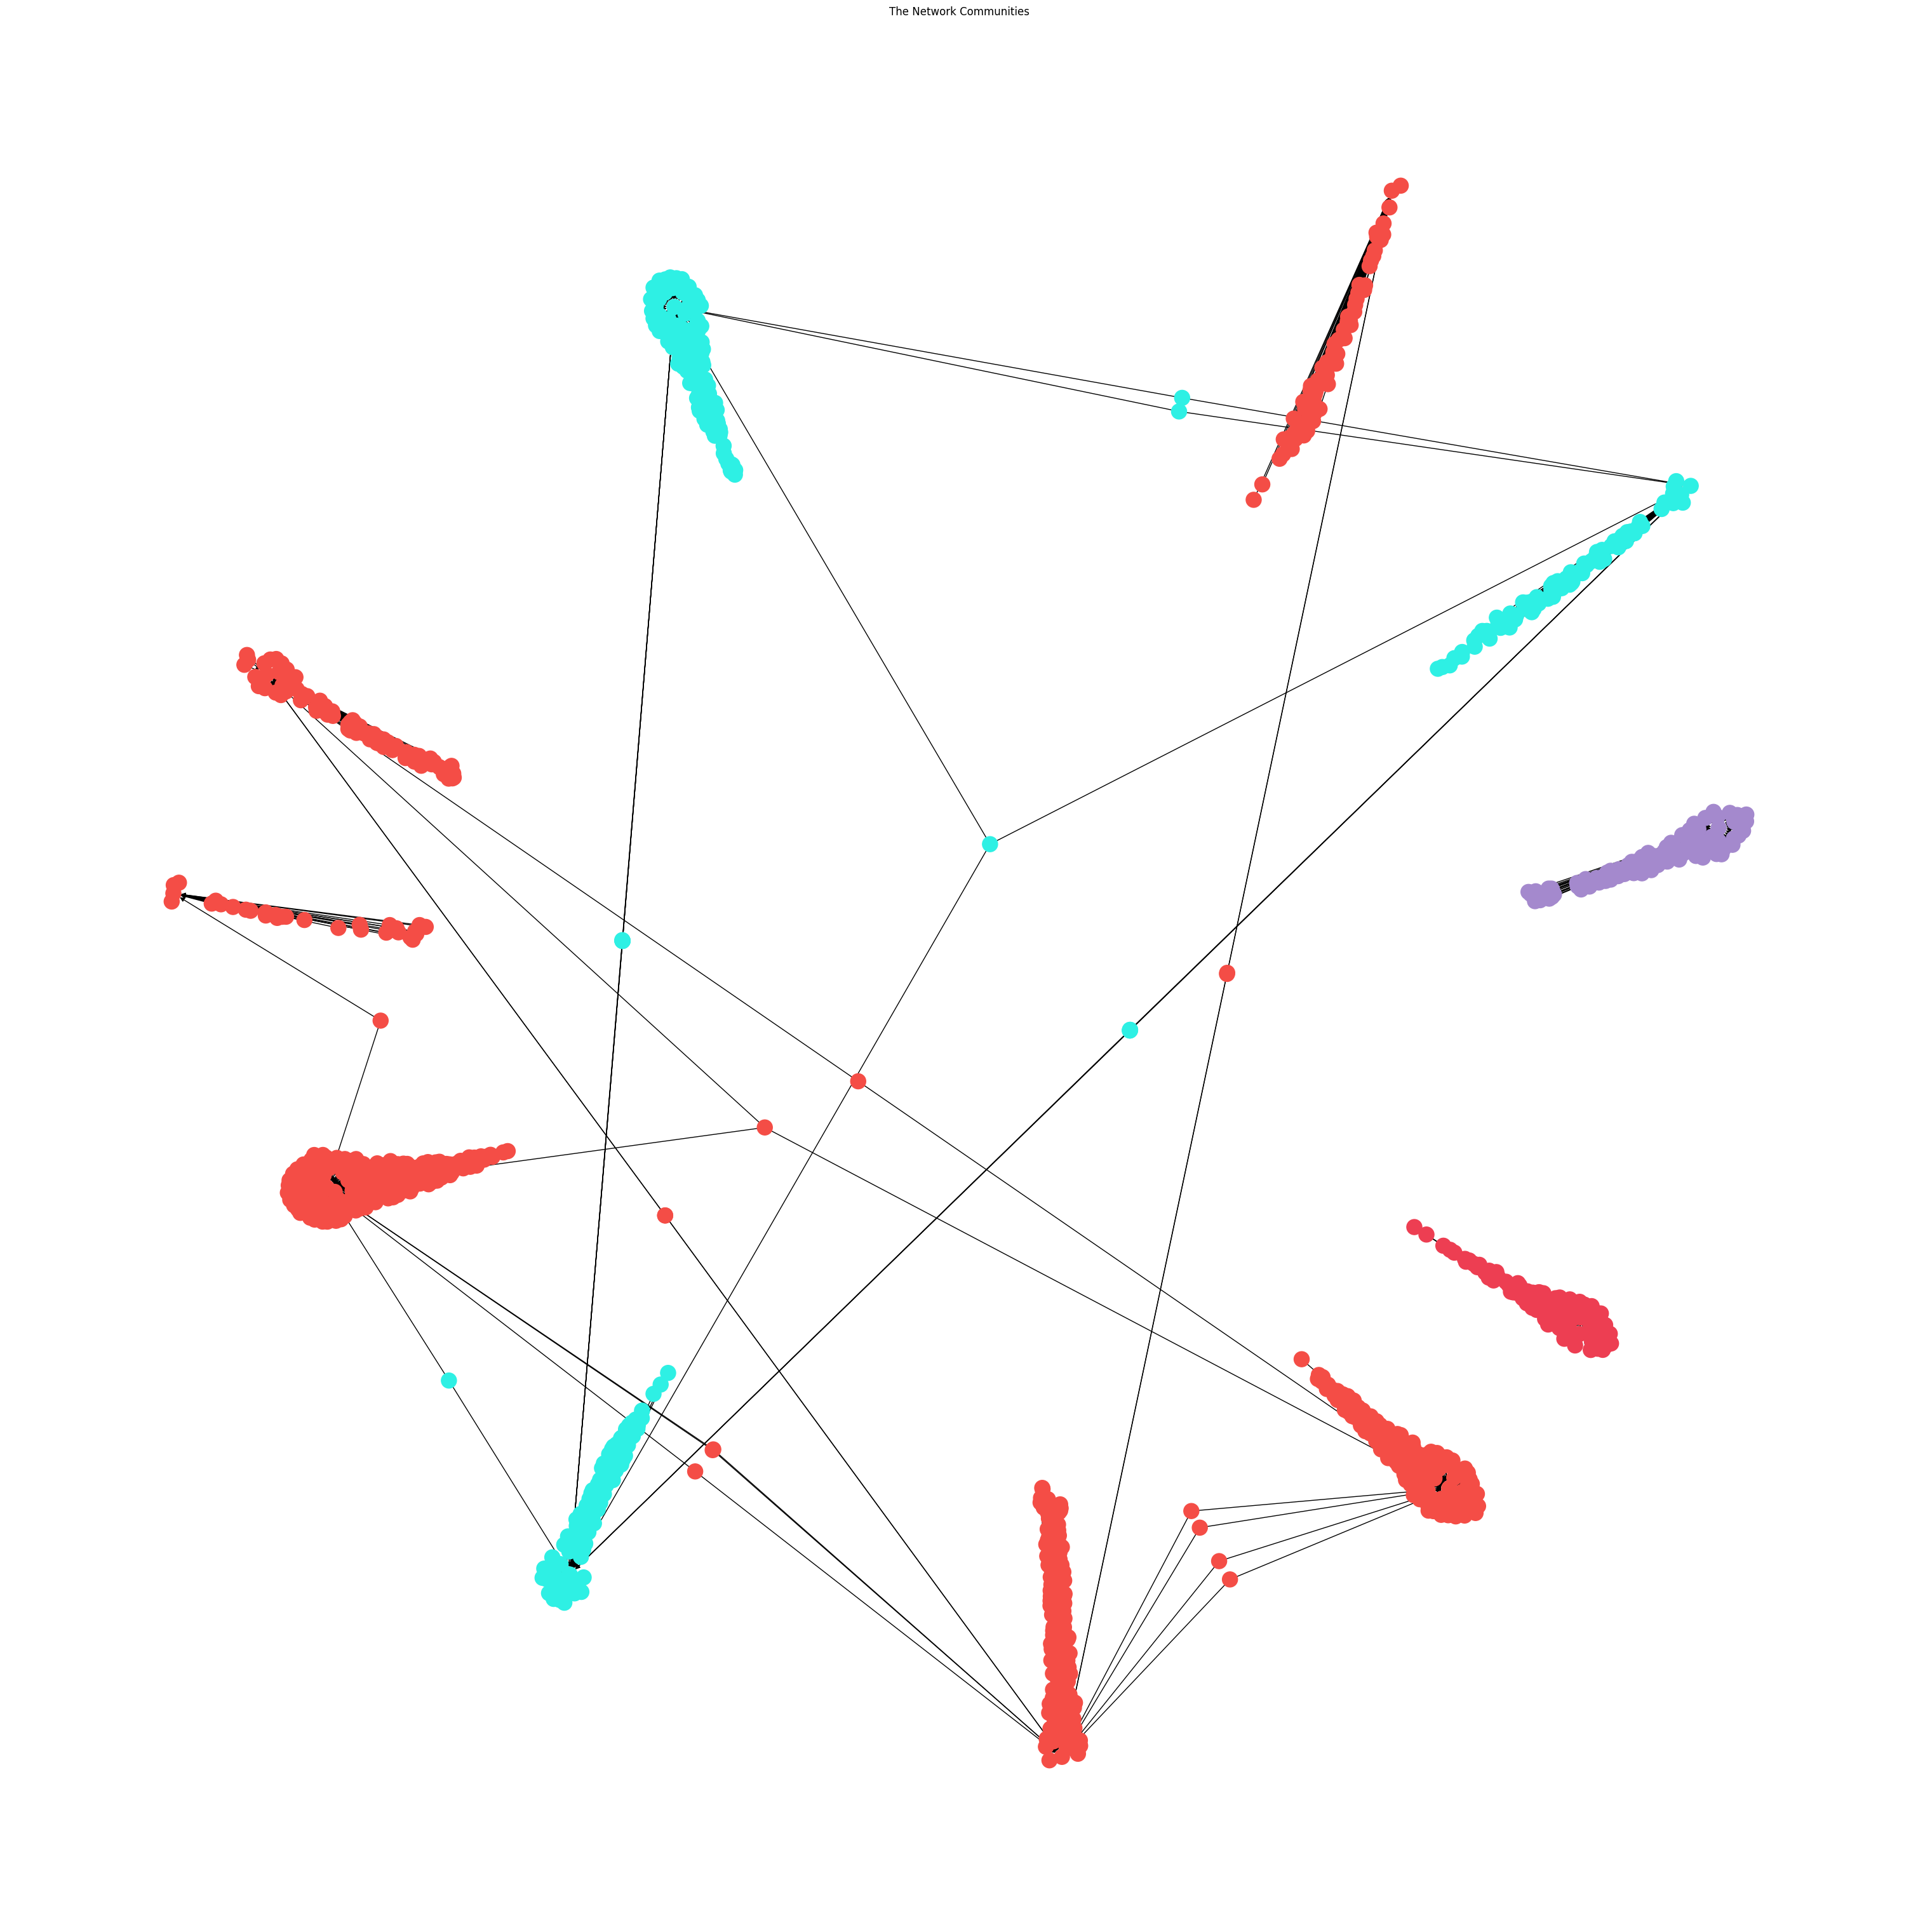

In [35]:
communities = girvan_newman(Net)

node_groups = []
for com in next(communities):
    node_groups.append(list(com))

colors = ["#%06x" % np.random.randint(0, 0xFFFFFF) for _ in range(len(node_groups))]

color_map = []
for node in Net:
    for j in range(len(node_groups)):
        if node in node_groups[j]:
            color_map.append(colors[j])

plt.figure(figsize=(30, 30))            
nx.draw(Net, node_color=color_map, with_labels=False)
plt.title("The Network Communities")
plt.show()

# Showing the Most Active Communities

In [36]:
like_counter = []
for group in tqdm(node_groups):
    cnt = 0
    for name in group:
        for idx in range(len(likes)):
            if likes['name'][idx] == name:
                cnt += 1
    
    like_counter.append(cnt)

100%|██████████| 4/4 [00:08<00:00,  2.02s/it]


## Finding the Community Leaders

In [37]:
leaders = []
for group in tqdm(node_groups):
    max_likes = -1
    name_max = ""
    for name in group:
        temp = Net.degree(name)
        if temp > max_likes:
            max_likes = temp
            name_max = name

    leaders.append(name_max)

100%|██████████| 4/4 [00:00<00:00, 2492.53it/s]


In [38]:
print("============================================================")
print("\t THE MOST ACTIVE Communities ARE:")
print("============================================================")
for _ in range(len(node_groups)):
    print(f"{_ + 1}: Commnuity Leader: {leaders[_]}, #Of Likes: {like_counter[_]}")

	 THE MOST ACTIVE Communities ARE:
1: Commnuity Leader: The Guardian, #Of Likes: 940
2: Commnuity Leader: BBC News فارسی, #Of Likes: 438
3: Commnuity Leader: IRAN, #Of Likes: 164
4: Commnuity Leader: Iran l ایران, #Of Likes: 105


# Setup ElasticSearch

In [39]:
from elasticsearch import helpers, Elasticsearch
ES_USERNAME = 'elastic'
ES_PASS = 'Sajadi4657'

In [40]:
es = Elasticsearch('https://localhost:9200', ca_certs="../elasticsearch-8.12.0-windows-x86_64/elasticsearch-8.12.0/config/certs/http_ca.crt", basic_auth=(ES_USERNAME,ES_PASS))

print(es.ping())

True


## Create an Index

In [41]:
POST_INDEX_NAME = 'facebook_posts'
LIKE_INDEX_NAME = 'facebook_likes'
KEYWORD_INDEX_NAME = 'facebook_keywords'

In [42]:
# if es.indices.exists(index=POST_INDEX_NAME):
#     es.indices.delete(index=POST_INDEX_NAME, ignore=[400, 404])
# es.indices.create(index=POST_INDEX_NAME)
if not es.indices.exists(index=POST_INDEX_NAME):
    es.indices.create(index=POST_INDEX_NAME)

C:\Users\sorou\AppData\Local\Temp\ipykernel_7928\1714061670.py:2: DeprecationWarning: Passing transport options in the API method is deprecated. Use 'Elasticsearch.options()' instead.
  es.indices.delete(index=POST_INDEX_NAME, ignore=[400, 404])


ObjectApiResponse({'acknowledged': True, 'shards_acknowledged': True, 'index': 'facebook_posts'})

In [43]:
# if es.indices.exists(index=LIKE_INDEX_NAME):
#     es.indices.delete(index=LIKE_INDEX_NAME, ignore=[400, 404])
# es.indices.create(index=LIKE_INDEX_NAME)
if not es.indices.exists(index=LIKE_INDEX_NAME):
    es.indices.create(index=LIKE_INDEX_NAME)

C:\Users\sorou\AppData\Local\Temp\ipykernel_7928\739440850.py:2: DeprecationWarning: Passing transport options in the API method is deprecated. Use 'Elasticsearch.options()' instead.
  es.indices.delete(index=LIKE_INDEX_NAME, ignore=[400, 404])


ObjectApiResponse({'acknowledged': True, 'shards_acknowledged': True, 'index': 'facebook_likes'})

In [44]:
# if es.indices.exists(index=KEYWORD_INDEX_NAME):
#     es.indices.delete(index=KEYWORD_INDEX_NAME, ignore=[400, 404])
# es.indices.create(index=KEYWORD_INDEX_NAME)
if not es.indices.exists(index=KEYWORD_INDEX_NAME):
    es.indices.create(index=KEYWORD_INDEX_NAME)

C:\Users\sorou\AppData\Local\Temp\ipykernel_7928\476919288.py:2: DeprecationWarning: Passing transport options in the API method is deprecated. Use 'Elasticsearch.options()' instead.
  es.indices.delete(index=KEYWORD_INDEX_NAME, ignore=[400, 404])


ObjectApiResponse({'acknowledged': True, 'shards_acknowledged': True, 'index': 'facebook_keywords'})

# Create JSON Files for sending to Elastic Search

In [45]:
import json

In [46]:
post_res = []

for idx in tqdm(range(len(posts))):
    temp = dict()
    temp['user'] = posts['user/name'][idx]
    temp['post'] = str(posts['text'][idx])
    temp['post_preprocessed'] = sentimented_df['text'][idx]
    temp['time'] = posts['time'][idx]
    temp['likes'] = str(posts['likes'][idx])
    temp['sentiment'] = sentimented_df['sentiment'][idx]
    post_res.append(json.dumps(temp, ensure_ascii=False))

post_res[0]

100%|██████████| 739/739 [00:00<00:00, 28343.26it/s]


'{"user": "The New York Times", "post": "This pen has been Wirecutter\'s favorite for a decade. It’s unassuming. But it’s special.", "post_preprocessed": "pen wirecutters favorite decade ’ unassuming ’ special", "time": "2024-01-19T16:50:03.000Z", "likes": "11", "sentiment": "Positive"}'

In [47]:
likes_res = []

for idx in tqdm(range(len(likes))):
    temp = dict()
    temp['user'] = likes['name'][idx]
    temp['reaction'] = likes['reaction'][idx]
    likes_res.append(json.dumps(temp, ensure_ascii=False))

likes_res[0]

100%|██████████| 1647/1647 [00:00<00:00, 84334.64it/s]


'{"user": "Tom Traub", "reaction": "like"}'

In [48]:
keyword_res = []

for idx in tqdm(range(len(KeyWords_df))):
    temp = dict()
    temp['keyword'] = KeyWords_df['word'][idx]
    temp['repeat'] = str(KeyWords_df['repeat'][idx])
    temp['sentiment'] = KeyWords_df['sentiment'][idx]
    keyword_res.append(json.dumps(temp, ensure_ascii=False))

keyword_res[0]

100%|██████████| 25/25 [00:00<00:00, 12514.33it/s]


'{"keyword": "ایران", "repeat": "256", "sentiment": "Neutral"}'

# Sending data to ES

In [49]:
for idx in tqdm(range(len(post_res))):
    es.index(index=POST_INDEX_NAME, body=post_res[idx])

100%|██████████| 739/739 [00:02<00:00, 284.77it/s]


In [50]:
for idx in tqdm(range(len(likes_res))):
    es.index(index=LIKE_INDEX_NAME, body=likes_res[idx])

100%|██████████| 1647/1647 [00:05<00:00, 302.56it/s]


In [51]:
for idx in tqdm(range(len(keyword_res))):
    es.index(index=KEYWORD_INDEX_NAME, body=keyword_res[idx])

100%|██████████| 25/25 [00:00<00:00, 140.63it/s]


# Test a Query

In [52]:
es.search(index=POST_INDEX_NAME, query={"match_all": {}})

ObjectApiResponse({'took': 1, 'timed_out': False, '_shards': {'total': 1, 'successful': 1, 'skipped': 0, 'failed': 0}, 'hits': {'total': {'value': 739, 'relation': 'eq'}, 'max_score': 1.0, 'hits': [{'_index': 'facebook_posts', '_id': 'jGwzQI0BJAjVANpYG5oi', '_score': 1.0, '_source': {'user': 'The New York Times', 'post': "This pen has been Wirecutter's favorite for a decade. It’s unassuming. But it’s special.", 'post_preprocessed': 'pen wirecutters favorite decade ’ unassuming ’ special', 'time': '2024-01-19T16:50:03.000Z', 'likes': '11', 'sentiment': 'Positive'}}, {'_index': 'facebook_posts', '_id': 'jWwzQI0BJAjVANpYG5qS', '_score': 1.0, '_source': {'user': 'Guardian US', 'post': 'nan', 'post_preprocessed': 'nan', 'time': '2024-01-19T16:47:16.000Z', 'likes': '0', 'sentiment': 'Neutral'}}, {'_index': 'facebook_posts', '_id': 'jmwzQI0BJAjVANpYG5qX', '_score': 1.0, '_ignored': ['post.keyword'], '_source': {'user': 'The New York Times', 'post': 'From The Athletic FC: In over six seasons a

In [53]:
es.search(index=LIKE_INDEX_NAME, query={"match_all": {}})

ObjectApiResponse({'took': 1, 'timed_out': False, '_shards': {'total': 1, 'successful': 1, 'skipped': 0, 'failed': 0}, 'hits': {'total': {'value': 1647, 'relation': 'eq'}, 'max_score': 1.0, 'hits': [{'_index': 'facebook_likes', '_id': 'b2wzQI0BJAjVANpYKJ2c', '_score': 1.0, '_source': {'user': 'Tom Traub', 'reaction': 'like'}}, {'_index': 'facebook_likes', '_id': 'cGwzQI0BJAjVANpYKJ3z', '_score': 1.0, '_source': {'user': 'Kaung Sett', 'reaction': 'like'}}, {'_index': 'facebook_likes', '_id': 'cWwzQI0BJAjVANpYKJ33', '_score': 1.0, '_source': {'user': 'لعل محمد ابراهیمی', 'reaction': 'like'}}, {'_index': 'facebook_likes', '_id': 'cmwzQI0BJAjVANpYKJ38', '_score': 1.0, '_source': {'user': 'محمد عیسی محمدی', 'reaction': 'like'}}, {'_index': 'facebook_likes', '_id': 'c2wzQI0BJAjVANpYKZ0A', '_score': 1.0, '_source': {'user': 'Mohamad Zoyavar', 'reaction': 'like'}}, {'_index': 'facebook_likes', '_id': 'dGwzQI0BJAjVANpYKZ0F', '_score': 1.0, '_source': {'user': 'Shafi Khan', 'reaction': 'like'}},

In [54]:
es.search(index=KEYWORD_INDEX_NAME, query={"match_all": {}})

ObjectApiResponse({'took': 0, 'timed_out': False, '_shards': {'total': 1, 'successful': 1, 'skipped': 0, 'failed': 0}, 'hits': {'total': {'value': 25, 'relation': 'eq'}, 'max_score': 1.0, 'hits': [{'_index': 'facebook_keywords', '_id': '3mwzQI0BJAjVANpYQaOG', '_score': 1.0, '_source': {'keyword': 'ایران', 'repeat': '256', 'sentiment': 'Neutral'}}, {'_index': 'facebook_keywords', '_id': '32wzQI0BJAjVANpYQaPh', '_score': 1.0, '_source': {'keyword': 'پاکستان', 'repeat': '198', 'sentiment': 'Neutral'}}, {'_index': 'facebook_keywords', '_id': '4GwzQI0BJAjVANpYQaPl', '_score': 1.0, '_source': {'keyword': 'حمله', 'repeat': '135', 'sentiment': 'Neutral'}}, {'_index': 'facebook_keywords', '_id': '4WwzQI0BJAjVANpYQaPr', '_score': 1.0, '_source': {'keyword': 'کشور', 'repeat': '120', 'sentiment': 'Neutral'}}, {'_index': 'facebook_keywords', '_id': '4mwzQI0BJAjVANpYQaPv', '_score': 1.0, '_source': {'keyword': 'روز', 'repeat': '92', 'sentiment': 'Neutral'}}, {'_index': 'facebook_keywords', '_id': '4